# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [194]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [28]:
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
def assess_df(df):
    """
    Simple function to combine various pandas tools to view the data.
    includes info(), describe(), isnull().sum()
    
    Argument:
    Pandas DataFrame
    
    Output:
    
    Print out of DataFrame info, statistical description, and Null value count
    """
    
    pd.options.display.float_format = '{:.8f}'.format
    
    print("*DATAFRAME INFORMATION*")
    print(df.info())
    print()      
    # statistical description
    print("*STATISTICAL DESCRIPTION*")
    print(df.describe())
    print()
    # Count of null rows per column
    print("*MISSING VALUES COUNT*")
    print(df.isnull().sum())
    
assess_df(portfolio)

*DATAFRAME INFORMATION*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None

*STATISTICAL DESCRIPTION*
           reward  difficulty    duration
count 10.00000000 10.00000000 10.00000000
mean   4.20000000  7.70000000  6.50000000
std    3.58391468  5.83190459  2.32139805
min    0.00000000  0.00000000  3.00000000
25%    2.00000000  5.00000000  5.00000000
50%    4.00000000  8.50000000  7.00000000
75%    5.00000000 10.00000000  7.00000000
max   10.00000000 20.00000000 10.00000000

*MISSING VALUES COUNT*
reward        0
channels      0
difficulty    0
duration      0
of

In [30]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [31]:
assess_df(profile)

*DATAFRAME INFORMATION*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None

*STATISTICAL DESCRIPTION*
                 age  became_member_on          income
count 17000.00000000    17000.00000000  14825.00000000
mean     62.53141176 20167034.23411765  65404.99156830
std      26.73857995    11677.49996079  21598.29941023
min      18.00000000 20130729.00000000  30000.00000000
25%      45.00000000 20160526.00000000  49000.00000000
50%      58.00000000 20170802.00000000  64000.00000000
75%      73.00000000 20171230.00000000  80000.00000000
max

In [32]:
profile.head()

gender  age                                id  became_member_on  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804   

           income  
0             nan  
1 112000.00000000  
2             nan  
3 100000.00000000  
4             nan

In [33]:
assess_df(transcript)

*DATAFRAME INFORMATION*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None

*STATISTICAL DESCRIPTION*
                 time
count 306534.00000000
mean     366.38293958
std      200.32631352
min        0.00000000
25%      186.00000000
50%      408.00000000
75%      528.00000000
max      714.00000000

*MISSING VALUES COUNT*
person    0
event     0
value     0
time      0
dtype: int64


In [34]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [156]:
print('Portfolio: ', portfolio.head(1))
print('Profile: ', profile.head(1))
print('Transcript: ', transcript.head(1))

Portfolio:     reward                 channels  difficulty  duration offer_type  \
0      10  [email, mobile, social]          10         7       bogo   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
Profile:    gender  age                                id  became_member_on  income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     nan
Transcript:                               person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   

                                              value  time  amounts  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0      nan  


In [148]:
amounts_loc = transcript.loc[transcript['event']=='transaction']['value']
amounts = [x.get('amount', np.nan) for x in amounts_loc]

In [151]:
amounts = pd.DataFrame(amounts)

In [153]:
pd.concat([amounts_loc, amounts], axis=1)

value           0
0                                  NaN  0.83000000
1                                  NaN 34.56000000
2                                  NaN 13.23000000
3                                  NaN 19.51000000
4                                  NaN 18.97000000
...                                ...         ...
306529  {'amount': 1.5899999999999999}         nan
306530                {'amount': 9.53}         nan
306531                {'amount': 3.61}         nan
306532  {'amount': 3.5300000000000002}         nan
306533                {'amount': 4.05}         nan

[216061 rows x 2 columns]

In [145]:
transcript.loc[transcript['event']=='transaction']['amounts'].sum()

0.0

In [118]:
transcript['amounts'] = np.nan

In [135]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [128]:
clean_df['offer_id'] = clean_df['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'] if 'offer_id' in x else np.nan)

In [129]:
amounts

[0.8300000000000001,
 34.56,
 13.23,
 19.51,
 18.97,
 33.9,
 0.22,
 18.59,
 18.01,
 19.11,
 36.19,
 6.46,
 5.02,
 28.39,
 28.08,
 0.75,
 1.02,
 13.57,
 10.22,
 31.42,
 27.89,
 4.2,
 13.05,
 1.16,
 38.38,
 4.08,
 5.78,
 14.27,
 11.52,
 13.93,
 18.97,
 4.05,
 30.03,
 21.84,
 10.37,
 1.21,
 5.46,
 7.4,
 2.95,
 19.82,
 11.83,
 5.31,
 2.44,
 3.26,
 24.8,
 1.23,
 17.0,
 5.95,
 11.76,
 3.45,
 6.32,
 1.3900000000000001,
 18.98,
 4.27,
 4.26,
 0.05,
 24.98,
 18.05,
 14.74,
 15.72,
 12.88,
 18.57,
 7.61,
 6.11,
 8.66,
 8.99,
 3.4,
 2.41,
 24.38,
 18.11,
 1.22,
 1.33,
 25.07,
 22.22,
 7.66,
 18.47,
 12.72,
 13.37,
 11.62,
 5.62,
 2.41,
 13.42,
 0.23,
 13.01,
 21.34,
 39.64,
 0.54,
 26.47,
 1.0,
 2.89,
 9.33,
 14.93,
 3.69,
 2.04,
 2.49,
 2.04,
 4.43,
 11.29,
 16.34,
 2.08,
 2.26,
 9.96,
 8.55,
 22.87,
 24.72,
 7.51,
 2.31,
 2.65,
 2.24,
 1.6800000000000002,
 17.17,
 1.7000000000000002,
 1.01,
 12.09,
 0.52,
 6.15,
 1.06,
 12.07,
 0.8,
 1.26,
 4.85,
 20.46,
 33.56,
 23.29,
 2.18,
 1.13,
 1.51,
 26

In [133]:
transcript['amounts'] = np.nan
transcript.loc[transcript['event']=='transaction']['amounts'] = x for x in amounts

SyntaxError: invalid syntax (<ipython-input-133-1a6be8fdc8d7>, line 2)

In [ ]:
transcript

In [132]:
transcript.loc[transcript['event']=='transaction'].head()

person        event  \
12654  02c083884c7d45b39cc68e1314fec56c  transaction   
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  transaction   
12659  54890f68699049c2a04d415abc25e717  transaction   
12670  b2f1cd155b864803ad8334cdf13c4bd2  transaction   
12671  fe97aa22dd3e48c8b143116a8403dd52  transaction   

                                value  time  amounts  
12654  {'amount': 0.8300000000000001}     0      nan  
12657               {'amount': 34.56}     0      nan  
12659               {'amount': 13.23}     0      nan  
12670               {'amount': 19.51}     0      nan  
12671               {'amount': 18.97}     0      nan

In [ ]:
def value_parser(df = transcript):
    amounts = transcript.loc[transcript['event']=='transaction']['value']
    amounts = [x.get('amount', np.nan) for x in amounts]
    transcript['amounts'] = np.nan
    transcript.loc[transcript['event']=='transaction']['amounts'] = amounts
    

In [107]:
offer_ids = [x.get('offer id') for x in transcript.value if 'offer id' in x else x.get('amount')]

SyntaxError: invalid syntax (<ipython-input-107-1638a09a1845>, line 1)

In [102]:
offer_ids

['9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2906b810c7d4411798c6938adc9daaa5',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '3f207df678b143eea3cee63160fa8bed',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '3f207df678b143eea3cee63160fa8bed',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2906b810c7d4411798c6938adc9daaa5',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '2906b810c7d4411798c6938adc9daaa5',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '2906b810c7d4411798c6938adc9daaa5',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '2906b810c7d4411798c6938adc9daaa5',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 

In [90]:
def value_parser():
    if 'offer id' in x:
        [d.get('offer id') for d in transcript.value]
    elif 'offer_id' in x:
        
    else:
        [d.get('amount', 0) for d in transcript.value]

[0.8300000000000001,
 34.56,
 13.23,
 19.51,
 18.97,
 33.9,
 0.22,
 18.59,
 18.01,
 19.11,
 36.19,
 6.46,
 5.02,
 28.39,
 28.08,
 0.75,
 1.02,
 13.57,
 10.22,
 31.42,
 27.89,
 4.2,
 13.05,
 1.16,
 38.38,
 4.08,
 5.78,
 14.27,
 11.52,
 13.93,
 18.97,
 4.05,
 30.03,
 21.84,
 10.37,
 1.21,
 5.46,
 7.4,
 2.95,
 19.82,
 11.83,
 5.31,
 2.44,
 3.26,
 24.8,
 1.23,
 17.0,
 5.95,
 11.76,
 3.45,
 6.32,
 1.3900000000000001,
 18.98,
 4.27,
 4.26,
 0.05,
 24.98,
 18.05,
 14.74,
 15.72,
 12.88,
 18.57,
 7.61,
 6.11,
 8.66,
 8.99,
 3.4,
 2.41,
 24.38,
 18.11,
 1.22,
 1.33,
 25.07,
 22.22,
 7.66,
 18.47,
 12.72,
 13.37,
 11.62,
 5.62,
 2.41,
 13.42,
 0.23,
 13.01,
 21.34,
 39.64,
 0.54,
 26.47,
 1.0,
 2.89,
 9.33,
 14.93,
 3.69,
 2.04,
 2.49,
 2.04,
 4.43,
 11.29,
 16.34,
 2.08,
 2.26,
 9.96,
 8.55,
 22.87,
 24.72,
 7.51,
 2.31,
 2.65,
 2.24,
 1.6800000000000002,
 17.17,
 1.7000000000000002,
 1.01,
 12.09,
 0.52,
 6.15,
 1.06,
 12.07,
 0.8,
 1.26,
 4.85,
 20.46,
 33.56,
 23.29,
 2.18,
 1.13,
 1.51,
 26

In [174]:
offer_ids = transcript.value.str.contains('offer_id', regex=False)

In [175]:
offer_ids

0         False
1         False
2         False
3         False
4         False
          ...  
306529    False
306530    False
306531    False
306532    False
306533    False
Name: value, Length: 306534, dtype: bool

In [160]:
transcript["value"].apply(lambda x: x["offer id"] 
                                   if "offer id" in x 
                                   else (x["offer_id"] 
                                         if "offer_id" in x 
                                         else 0))

9b98b8c7a33c4b65b9aebfe6a799e6d9
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678b143eea3cee63160fa8bed
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
0b1e1539f2cc45b7b9fa7c272da2e1d7
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a3

2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a

4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678

fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
0b1e1539f2cc45b7b9fa7c272da2e1d7
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7

3f207df678b143eea3cee63160fa8bed
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e

4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
0b1e1539f2cc45b7b9fa7c272da2e1d7
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e

ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
3f207df678b143eea3cee63160fa8bed
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678b143eea3cee63160fa8bed
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
9b98b8c7a33c4b65b9aebfe6a799e6d9
3f207df678b143eea3cee63160fa8bed
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7

f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
9b98b8c7a33c4b65b9aebfe6a799e6d9
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e

3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637

4d5c57ea9a6940dd891ad53e9dbe8da0
0b1e1539f2cc45b7b9fa7c272da2e1d7
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678b143eea3cee63160fa8bed
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a3

4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
ae264e3637204a6fb9bb56bc8210ddfd
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990

5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a33c4b65b9aebfe6a799e6d9
fafdcd668e

9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a

2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
9b98b8c7a33c4b65b9aebfe6a799e6d9
3f207df678b143eea3cee63160fa8bed
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2

5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
0b1e1539f2

4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
fafdcd668e3743c1bb461111dcafc2a4
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
2298d6c36e

5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a

9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a3

ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
0b1e1539f2cc45b7b9fa7c272da2e1d7
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990

2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
f19421c1d4aa40978ebb69ca19b0e20d
0b1e1539f2cc45b7b9fa7c272da2e1d7
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990

f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
3f207df678b143eea3cee63160fa8bed
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
0b1e1539f2cc45b7b9fa7c272da2e1d7
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
0b1e1539f2

9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
5a8bc65990

5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e

ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
0b1e1539f2cc45b7b9fa7c272da2e1d7
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e

2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
0b1e1539f2cc45b7b9fa7c272da2e1d7
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e

3f207df678b143eea3cee63160fa8bed
9b98b8c7a33c4b65b9aebfe6a799e6d9
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
3f207df678b143eea3cee63160fa8bed
0b1e1539f2

2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990

ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
0b1e1539f2cc45b7b9fa7c272da2e1d7
f19421c1d4aa40978ebb69ca19b0e20d
3f207df678b143eea3cee63160fa8bed
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
0b1e1539f2cc45b7b9fa7c272da2e1d7
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990

fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
ae264e3637204a6fb9bb56bc8210ddfd
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
3f207df678b143eea3cee63160fa8bed
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
0b1e1539f2cc45b7b9fa7c272da2e1d7
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a

9b98b8c7a33c4b65b9aebfe6a799e6d9
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
9b98b8c7a33c4b65b9aebfe6a799e6d9
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
9b98b8c7a33c4b65b9aebfe6a799e6d9
0b1e1539f2cc45b7b9fa7c272da2e1d7
fafdcd668e3743c1bb461111dcafc2a4
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
f19421c1d4aa40978ebb69ca19b0e20d
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
fafdcd668e

3f207df678b143eea3cee63160fa8bed
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
3f207df678b143eea3cee63160fa8bed
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
5a8bc65990b245e5a138643cd4eb9837
3f207df678b143eea3cee63160fa8bed
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e

5a8bc65990b245e5a138643cd4eb9837
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
2906b810c7d4411798c6938adc9daaa5
2906b810c7d4411798c6938adc9daaa5
0b1e1539f2cc45b7b9fa7c272da2e1d7
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
9b98b8c7a33c4b65b9aebfe6a799e6d9
2298d6c36e964ae4a3e7e9706d1fb8c2
0b1e1539f2cc45b7b9fa7c272da2e1d7
fafdcd668e3743c1bb461111dcafc2a4
ae264e3637204a6fb9bb56bc8210ddfd
4d5c57ea9a6940dd891ad53e9dbe8da0
ae264e3637204a6fb9bb56bc8210ddfd
9b98b8c7a33c4b65b9aebfe6a799e6d9
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
f19421c1d4aa40978ebb69ca19b0e20d
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a

fafdcd668e3743c1bb461111dcafc2a4
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
ae264e3637204a6fb9bb56bc8210ddfd
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
4d5c57ea9a6940dd891ad53e9dbe8da0
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
9b98b8c7a33c4b65b9aebfe6a799e6d9
3f207df678b143eea3cee63160fa8bed
4d5c57ea9a6940dd891ad53e9dbe8da0
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
2298d6c36e964ae4a3e7e9706d1fb8c2
f19421c1d4aa40978ebb69ca19b0e20d
2298d6c36e964ae4a3e7e9706d1fb8c2
3f207df678b143eea3cee63160fa8bed
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
4d5c57ea9a6940dd891ad53e9dbe8da0
2906b810c7d4411798c6938adc9daaa5
fafdcd668e3743c1bb461111dcafc2a4
2298d6c36e964ae4a3e7e9706d1fb8c2
ae264e3637204a6fb9bb56bc8210ddfd
5a8bc65990

ae264e3637204a6fb9bb56bc8210ddfd
fafdcd668e3743c1bb461111dcafc2a4
5a8bc65990b245e5a138643cd4eb9837
4d5c57ea9a6940dd891ad53e9dbe8da0
fafdcd668e3743c1bb461111dcafc2a4
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
0b1e1539f2cc45b7b9fa7c272da2e1d7
3f207df678b143eea3cee63160fa8bed
2906b810c7d4411798c6938adc9daaa5
5a8bc65990b245e5a138643cd4eb9837
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
ae264e3637204a6fb9bb56bc8210ddfd
2906b810c7d4411798c6938adc9daaa5
f19421c1d4aa40978ebb69ca19b0e20d
f19421c1d4aa40978ebb69ca19b0e20d
4d5c57ea9a6940dd891ad53e9dbe8da0
3f207df678b143eea3cee63160fa8bed
2298d6c36e964ae4a3e7e9706d1fb8c2
0b1e1539f2cc45b7b9fa7c272da2e1d7
4d5c57ea9a6940dd891ad53e9dbe8da0
f19421c1d4aa40978ebb69ca19b0e20d
5a8bc65990b245e5a138643cd4eb9837
ae264e3637204a6fb9bb56bc8210ddfd
0b1e1539f2cc45b7b9fa7c272da2e1d7
5a8bc65990b245e5a138643cd4eb9837
2906b810c7d4411798c6938adc9daaa5
4d5c57ea9a6940dd891ad53e9dbe8da0
2298d6c36e964ae4a3e7e9706d1fb8c2
2298d6c36e

0         None
1         None
2         None
3         None
4         None
          ... 
306529       0
306530       0
306531       0
306532       0
306533       0
Name: value, Length: 306534, dtype: object

In [ ]:
df = transcript.merge(profile, left_on='person', right_on='id', how='outer')

In [54]:
full_df = df.merge(portfolio, left_on='id', right_on='id', how='outer')

In [197]:
portfolio.sort_values('id').head(1)

reward      channels  difficulty  duration offer_type  \
4       5  [web, email]          20        10   discount   

                                 id  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [198]:
profile.sort_values('id').head(1)

gender  age                                id  became_member_on  \
3793      M   33  0009655768c64bdeb2e877511632db8f          20170421   

             income  
3793 72000.00000000

In [199]:
transcript.head(1)

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0

In [215]:
profile.loc[profile.id=='78afa995795e4d85b5d9ceeca43f5fef'] # id value from transcript

gender  age                                id  became_member_on  \
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   

           income  
3 100000.00000000

In [216]:
transcript.loc[transcript.person=='0009655768c64bdeb2e877511632db8f'] # id value from profile

person            event  \
55972   0009655768c64bdeb2e877511632db8f   offer received   
77705   0009655768c64bdeb2e877511632db8f     offer viewed   
89291   0009655768c64bdeb2e877511632db8f      transaction   
113605  0009655768c64bdeb2e877511632db8f   offer received   
139992  0009655768c64bdeb2e877511632db8f     offer viewed   
153401  0009655768c64bdeb2e877511632db8f   offer received   
168412  0009655768c64bdeb2e877511632db8f      transaction   
168413  0009655768c64bdeb2e877511632db8f  offer completed   
187554  0009655768c64bdeb2e877511632db8f     offer viewed   
204340  0009655768c64bdeb2e877511632db8f   offer received   
228422  0009655768c64bdeb2e877511632db8f      transaction   
228423  0009655768c64bdeb2e877511632db8f  offer completed   
233413  0009655768c64bdeb2e877511632db8f     offer viewed   
237784  0009655768c64bdeb2e877511632db8f      transaction   
247879  0009655768c64bdeb2e877511632db8f   offer received   
258883  0009655768c64bdeb2e877511632db8f      transaction   
258884  0009655768c64bdeb2e877511632db8f  offer completed   
293497  0009655768c64bdeb2e877511632db8f      transaction   
300930  0009655768c64bdeb2e877511632db8f      transaction   
302205  0009655768c64bdeb2e877511632db8f      transaction   

                                                    value  time  
55972    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   168  
77705    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   192  
89291                                   {'amount': 22.16}   228  
113605   {'offer id': '3f207df678b143eea3cee63160fa8bed'}   336  
139992   {'offer id': '3f207df678b143eea3cee63160fa8bed'}   372  
153401   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   408  
168412                                   {'amount': 8.57}   414  
168413  {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...   414  
187554   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   456  
204340   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   504  
228422                                  {'amount': 14.11}   528  
228423  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   528  
233413   {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   540  
237784                                  {'amount': 13.56}   552  
247879   {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   576  
258883                                  {'amount': 10.27}   576  
258884  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...   576  
293497                                  {'amount': 12.36}   660  
300930                                  {'amount': 28.16}   690  
302205                                  {'amount': 18.41}   696

In [217]:
df1 = portfolio.copy()
df1.dropna(inplace=True)
offer_type_dummies = pd.get_dummies(df1['offer_type'], prefix = str('offer_type')+ '_')
channels_dummies = (df1['channels'].str.join(sep='|')
                    .str.get_dummies(sep='|')
                    .add_prefix(str('channels')+ '_')
                   )
df1 = df1.drop(['channels', 'offer_type'], axis=1)

df1 = df1.rename(columns = {'id': 'offer_id', 
                          'reward': 'offer_reward', 
                          'difficulty': 'offer_difficulty', 
                          'duration': 'offer_duration'})
df1 = pd.concat([df1, offer_type_dummies, channels_dummies], axis=1)

In [218]:
df1

offer_reward  offer_difficulty  offer_duration  \
0            10                10               7   
1            10                10               5   
2             0                 0               4   
3             5                 5               7   
4             5                20              10   
5             3                 7               7   
6             2                10              10   
7             0                 0               3   
8             5                 5               5   
9             2                10               7   

                           offer_id  offer_type__bogo  offer_type__discount  \
0  ae264e3637204a6fb9bb56bc8210ddfd                 1                     0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0                 1                     0   
2  3f207df678b143eea3cee63160fa8bed                 0                     0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9                 1                     0   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7                 0                     1   
5  2298d6c36e964ae4a3e7e9706d1fb8c2                 0                     1   
6  fafdcd668e3743c1bb461111dcafc2a4                 0                     1   
7  5a8bc65990b245e5a138643cd4eb9837                 0                     0   
8  f19421c1d4aa40978ebb69ca19b0e20d                 1                     0   
9  2906b810c7d4411798c6938adc9daaa5                 0                     1   

   offer_type__informational  channels_email  channels_mobile  \
0                          0               1                1   
1                          0               1                1   
2                          1               1                1   
3                          0               1                1   
4                          0               1                0   
5                          0               1                1   
6                          0               1                1   
7                          1               1                1   
8                          0               1                1   
9                          0               1                1   

   channels_social  channels_web  
0                1             0  
1                1             1  
2                0             1  
3                0             1  
4                0             1  
5                1             1  
6                1             1  
7                1             0  
8                1             1  
9                0             1

In [408]:
df3 = transcript.copy()
df3 = df3.rename(columns = {'person': 'user_id'})

df3["amount"] = df3["value"].apply(lambda x: x["amount"] 
                                   if "amount" in x 
                                   else np.nan)
df3["id"] = df3["value"].apply(lambda x: x["offer id"] 
                               if "offer id" in x 
                               else (x["offer_id"] 
                                     if "offer_id" in x 
                                     else np.nan))

df3 = df3.rename(columns = {'id': 'offer_id'})

df3.drop('value', axis=1)

user_id           event  time     amount  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received     0        nan   
1       a03223e636434f42ac4c3df47e8bac43  offer received     0        nan   
2       e2127556f4f64592b11af22de27a7932  offer received     0        nan   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0        nan   
4       68617ca6246f4fbc85e91a2a49552598  offer received     0        nan   
...                                  ...             ...   ...        ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   714 1.59000000   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   714 9.53000000   
306531  a00058cf10334a308c68e7631c529907     transaction   714 3.61000000   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   714 3.53000000   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   714 4.05000000   

                                offer_id  
0       9b98b8c7a33c4b65b9aebfe6a799e6d9  
1       0b1e1539f2cc45b7b9fa7c272da2e1d7  
2       2906b810c7d4411798c6938adc9daaa5  
3       fafdcd668e3743c1bb461111dcafc2a4  
4       4d5c57ea9a6940dd891ad53e9dbe8da0  
...                                  ...  
306529                               NaN  
306530                               NaN  
306531                               NaN  
306532                               NaN  
306533                               NaN  

[306534 rows x 5 columns]

In [396]:
transcript.columns.tolist()

['person', 'event', 'value', 'time']

In [438]:
def clean_dataframe(df1 = portfolio, df2 = profile, df3 = transcript):
    
    '''
    Clean columns in dataframe

    Arguments:
        df1: portfolio DataFrame 
        df1: profile DataFrame 
        df1: transcript DataFrame 

    Output:
        df: Cleaned and concatenated DataFrames
    '''
    
    
    # Portfolio Dataframe cleaning
    # ['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'] (duration is in days)
    df1 = df1.copy()
    df1.dropna(inplace=True)
    offer_type_dummies = pd.get_dummies(df1['offer_type'], prefix = str('offer_type')+ '_')
    channels_dummies = (df1['channels'].str.join(sep='|')
                        .str.get_dummies(sep='|')
                        .add_prefix(str('channels')+ '_')
                       )
    # df1 = df1.drop(['channels', 'offer_type'], axis=1) # keep columns for ease of visualization
    
    df1 = df1.rename(columns = {'id': 'offer_id', 
                              'reward': 'offer_reward', 
                              'difficulty': 'offer_difficulty', 
                              'duration': 'offer_duration'})
    df1 = pd.concat([df1, offer_type_dummies, channels_dummies], axis=1)

    # Profile Dataframe cleaning
    # ['gender', 'age', 'id', 'became_member_on', 'income']
    df2 = df2.copy()
    df2 = df2.dropna()
    df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], 
                                             format = '%Y%m%d')
    df2 = df2.rename(columns = {'id': 'customer_id'}) 
    
    # Transcript Dataframe Cleaning
    # ['person', 'event', 'value', 'time'] (Time is in hours)
    df3 = df3.copy()
    df3 = df3.rename(columns = {'person': 'customer_id'})

    df3["amount"] = df3["value"].apply(lambda x: x["amount"] 
                                       if "amount" in x 
                                       else np.nan)
    df3["id"] = df3["value"].apply(lambda x: x["offer id"] 
                                   if "offer id" in x 
                                   else (x["offer_id"] 
                                         if "offer_id" in x 
                                         else np.nan))
    
    df3 = df3.rename(columns = {'id': 'offer_id'})
    df3['event_instance_days'] = df3['time']/24
    df3 = df3.drop('value', axis=1)
        
    df = pd.merge(df3, df2, how='left',on='customer_id')
    print(df.shape)
    df = pd.merge(df, df1, how='left', on='offer_id')
    print(df.shape)
    return df

In [439]:
df_combined = clean_dataframe()

(306534, 10)
(306534, 22)


In [444]:
print(df_combined.shape)
print(portfolio.shape[0] + profile.shape[0] + transcript.shape[0])
print(profile.id.nunique())
print(transcript.person.nunique())
print(df_combined.customer_id.nunique())
df_combined.sample(10)

(306534, 22)
323544
17000
17000
17000


customer_id            event  time      amount  \
63633   c4ccd694c25247fc82132a4a883bd1d1   offer received   168         nan   
202372  c3321bc76743445c9103eef0ce9d833b   offer received   504         nan   
277905  a425b937d8f245048313d81bee4e1745  offer completed   612         nan   
271384  3f4cf7d14e744e18a4912b9662c04152  offer completed   594         nan   
161668  52ca3e12464d464bad3ac645ef6f1030   offer received   408         nan   
197995  188c44a489374810aa61fdaeb47802e4      transaction   486 12.96000000   
169373  dcaa296e94ea4a6fb08347bd4e0bd35c     offer viewed   414         nan   
268970  0eca500cc9b449f2a134bcd37990d539     offer viewed   594         nan   
36721   03e866224ec641c58bc93a69be00de9c      transaction    72  4.11000000   
112304  1fc56d7bf27d4d3888625d67fb2ea306   offer received   336         nan   

                                offer_id  event_instance_days gender  \
63633   2298d6c36e964ae4a3e7e9706d1fb8c2           7.00000000      F   
202372  4d5c57ea9a6940dd891ad53e9dbe8da0          21.00000000      M   
277905  fafdcd668e3743c1bb461111dcafc2a4          25.50000000      M   
271384  4d5c57ea9a6940dd891ad53e9dbe8da0          24.75000000      F   
161668  9b98b8c7a33c4b65b9aebfe6a799e6d9          17.00000000      M   
197995                               NaN          20.25000000      M   
169373  5a8bc65990b245e5a138643cd4eb9837          17.25000000    NaN   
268970  2906b810c7d4411798c6938adc9daaa5          24.75000000      M   
36721                                NaN           3.00000000      F   
112304  4d5c57ea9a6940dd891ad53e9dbe8da0          14.00000000      F   

               age became_member_on         income  offer_reward  \
63633  65.00000000       2016-08-27 79000.00000000    3.00000000   
202372 76.00000000       2015-09-12 99000.00000000   10.00000000   
277905 39.00000000       2018-03-23 31000.00000000    2.00000000   
271384 53.00000000       2017-07-29 74000.00000000   10.00000000   
161668 56.00000000       2017-06-13 91000.00000000    5.00000000   
197995 48.00000000       2014-11-11 71000.00000000           nan   
169373         nan              NaT            nan    0.00000000   
268970 43.00000000       2018-03-27 31000.00000000    2.00000000   
36721  80.00000000       2018-02-11 47000.00000000           nan   
112304 57.00000000       2018-05-24 55000.00000000   10.00000000   

                            channels  offer_difficulty  offer_duration  \
63633   [web, email, mobile, social]        7.00000000      7.00000000   
202372  [web, email, mobile, social]       10.00000000      5.00000000   
277905  [web, email, mobile, social]       10.00000000     10.00000000   
271384  [web, email, mobile, social]       10.00000000      5.00000000   
161668          [web, email, mobile]        5.00000000      7.00000000   
197995                           NaN               nan             nan   
169373       [email, mobile, social]        0.00000000      3.00000000   
268970          [web, email, mobile]       10.00000000      7.00000000   
36721                            NaN               nan             nan   
112304  [web, email, mobile, social]       10.00000000      5.00000000   

           offer_type  offer_type__bogo  offer_type__discount  \
63633        discount        0.00000000            1.00000000   
202372           bogo        1.00000000            0.00000000   
277905       discount        0.00000000            1.00000000   
271384           bogo        1.00000000            0.00000000   
161668           bogo        1.00000000            0.00000000   
197995            NaN               nan                   nan   
169373  informational        0.00000000            0.00000000   
268970       discount        0.00000000            1.00000000   
36721             NaN               nan                   nan   
112304           bogo        1.00000000            0.00000000   

        offer_type__informational  channels_email  channels_mobile  \
63633           

In [349]:
plt.style.use('seaborn-dark-palette')

In [445]:
gender = df_combined.groupby(['event','gender'])['customer_id'].count().sort_values()

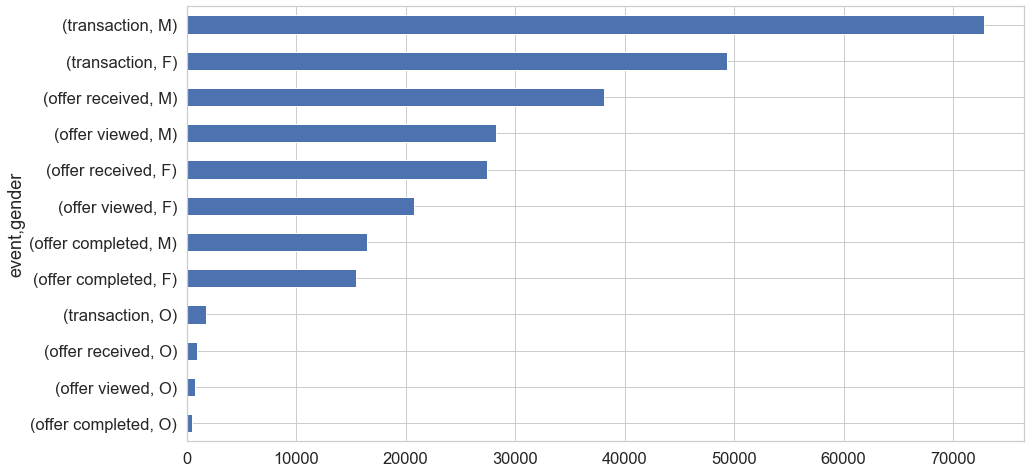

In [446]:
gender.plot.barh(figsize=(15,8));

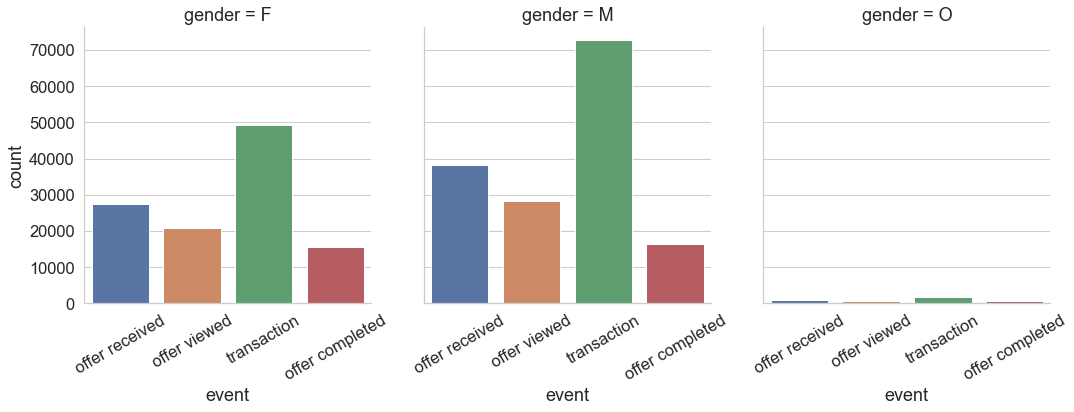

In [451]:
gender_event_plot = sns.catplot(data = df_combined, x = 'event', kind = 'count', col = 'gender', orient='h');
gender_event_plot.set_xticklabels(rotation=30);

In [355]:
import random

Text(0.5, 15.440000000000012, 'Age')

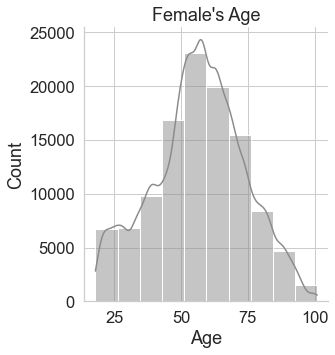

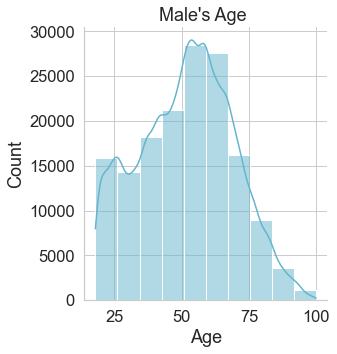

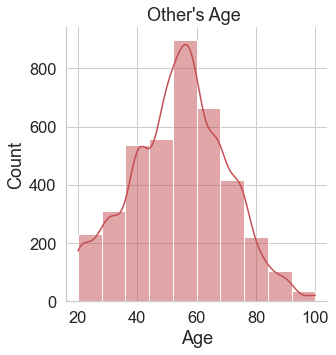

In [452]:
sns.set(style = 'whitegrid', font_scale = 1.5)
palette = sns.color_palette()

sns.displot(df_combined[df_combined['gender'] == 'F']['age'], bins = 10, color = palette[random.randint(0,9)], kde=True);
plt.title('Female\'s Age')
plt.xlabel('Age')
plt.ylabel('Count')

sns.displot(df_combined[df_combined['gender'] == 'M']['age'], bins = 10, color = palette[random.randint(0,9)],kde=True);
plt.title('Male\'s Age ')
plt.xlabel('Age')

sns.displot(df_combined[df_combined['gender'] == 'O']['age'], bins = 10, color = palette[random.randint(0,9)], kde=True);
plt.title('Other\'s Age ')
plt.xlabel('Age')

Text(0.5, 15.440000000000012, 'Income($)')

<Figure size 1152x432 with 0 Axes>

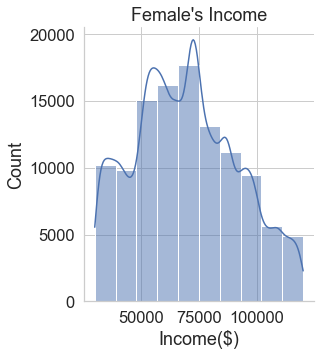

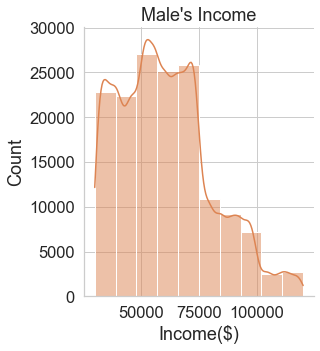

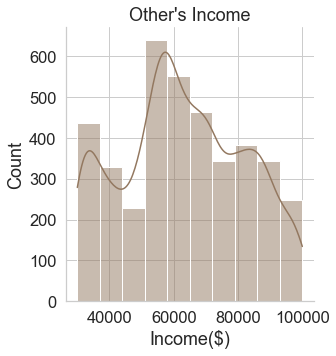

In [454]:
palette = sns.color_palette()

sns.displot(df_combined[df_combined['gender'] == 'F']['income'], bins = 10, color = palette[random.randint(0,9)], kde=True);
plt.title('Female\'s Income')
plt.xlabel('Income($)')
plt.ylabel('Count')

sns.displot(df_combined[df_combined['gender'] == 'M']['income'], bins = 10, color = palette[random.randint(0,9)], kde=True);
plt.title('Male\'s Income')
plt.xlabel('Income($)')

sns.displot(df_combined[df_combined['gender'] == 'O']['income'], bins = 10, color = palette[random.randint(0,9)], kde=True);
plt.title('Other\'s Income')
plt.xlabel('Income($)')

In [455]:
percentage = transcript['event'].value_counts()*100/len(transcript)
val_trans = percentage.values.tolist()
event_type = percentage.index.tolist()
sns.set(style = 'whitegrid', font_scale = 1.0)
import plotly.express as px
fig = px.pie(df_combined, 
             values = val_trans, 
             names = event_type, 
             color= event_type,
             color_discrete_map={'transaction':'lightcyan',
                                 'offer received':'cyan',
                                 'offer viewed':'royalblue',
                                 'offer completed':'darkblue'})

fig.show()

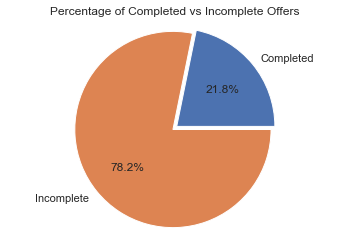

In [338]:
ones = (len(df_combined.loc[df_combined['event'] == 'offer received']) 
+ len(df_combined.loc[df_combined['event'] == 'offer viewed']))


zeros = len(df_combined['event']) - ones

labels = ['Completed', 'Incomplete']
sizes = [zeros, ones]
explode = (0, 0.05)
pie_plot = plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%')
plt.title('Percentage of Completed vs Incomplete Offers')
plt.axis('equal')
plt.show()

In [365]:
pd.set_option('display.max_columns', 500)

In [366]:
df_combined.head()

gender  age                       customer_id became_member_on  \
0      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   

           income            event  time  amount  \
0 112000.00000000   offer received   408     nan   
1 112000.00000000  offer completed   528     nan   
2 100000.00000000   offer received     0     nan   
3 100000.00000000     offer viewed     6     nan   
4 100000.00000000  offer completed   132     nan   

                           offer_id  offer_reward              channels  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9             5  [web, email, mobile]   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9             5  [web, email, mobile]   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9             5  [web, email, mobile]   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9             5  [web, email, mobile]   
4  9b98b8c7a33c4b65b9aebfe6a799e6d9             5  [web, email, mobile]   

   offer_difficulty  offer_duration offer_type  offer_type__bogo  \
0                 5               7       bogo                 1   
1                 5               7       bogo                 1   
2                 5               7       bogo                 1   
3                 5               7       bogo                 1   
4                 5               7       bogo                 1   

   offer_type__discount  offer_type__informational  channels_email  \
0                     0                          0               1   
1                     0                          0               1   
2                     0                          0               1   
3                     0                          0               1   
4                     0                          0               1   

   channels_mobile  channels_social  channels_web  
0                1                0             1  
1                1                0             1  
2                1                0             1  
3                1                0             1  
4                1                0             1

In [385]:
offer_type_event_by_time = df_combined.groupby(['offer_type', 'event'])['time'].mean().reset_index()

In [386]:
offer_type_event_by_time

offer_type            event         time
0           bogo  offer completed 391.71057806
1           bogo   offer received 332.76135207
2           bogo     offer viewed 353.46476700
3       discount  offer completed 406.63388805
4       discount   offer received 332.33483348
5       discount     offer viewed 354.64904393
6  informational   offer received 332.86375940
7  informational     offer viewed 356.89679487

In [390]:
fig = px.bar(offer_type_event_by_time, x='event', y='time', color='offer_type')

In [391]:
fig.show()

In [31]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org xgboost

In [32]:
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV

import xgboost
from xgboost import XGBClassifier

In [33]:

data = pd.read_csv('data/processed_data.csv')
data.head()

offer_id                       customer_id  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  0610b486422d4921ae7d2bf64640c50b   
1  3f207df678b143eea3cee63160fa8bed  0610b486422d4921ae7d2bf64640c50b   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9  78afa995795e4d85b5d9ceeca43f5fef   
3  5a8bc65990b245e5a138643cd4eb9837  78afa995795e4d85b5d9ceeca43f5fef   
4  ae264e3637204a6fb9bb56bc8210ddfd  78afa995795e4d85b5d9ceeca43f5fef   

   offer_completed  money_spent  offer_duration  offer_reward  \
0                0        23.22               7             5   
1                0        23.22               4             0   
2                1        37.67               7             5   
3                0        49.39               3             0   
4                1        48.28               7            10   

   offer_difficulty  offer_bogo  offer_discount  offer_informational  \
0                 5           1               0                    0   
1                 0           0               0                    1   
2                 5           1               0                    0   
3                 0           0               0                    1   
4                10           1               0                    0   

   channel_email  channel_mobile  channel_social  channel_web gender  age  \
0              1               1               0            1      F   55   
1              1               1               0            1      F   55   
2              1               1               0            1      F   75   
3              1               1               1            0      F   75   
4              1               1               1            0      F   75   

     income  days_membership  became_member_on  
0  112000.0             1258              2017  
1  112000.0             1258              2017  
2  100000.0             1325              2017  
3  100000.0             1325              2017  
4  100000.0             1325              2017

In [34]:
# Create dummies for gender, age, year
gender_dummies = pd.get_dummies(data['gender'], prefix = 'gender')
year_dummies = pd.get_dummies(data['became_member_on']).astype(int)

# For age use function process_cut
cut_points = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
data['age_cat'] = pd.cut(data['age'], cut_points)
age_dummies = pd.get_dummies(data['age_cat'])

data = pd.concat([data, gender_dummies, age_dummies, year_dummies], axis = 1)
data = data.drop(['age', 'age_cat', 'gender', 'became_member_on'], axis = 1)

column_normalize = ['money_spent', 'offer_duration', 'offer_reward', 
                    'offer_difficulty', 'income', 'days_membership']

for col in column_normalize:
    data[col] = minmax_scale(data[col])
    
data.columns = data.columns.astype(str)

In [35]:
data = shuffle(data)

In [36]:
data = data.drop(['channel_email'], axis = 1)

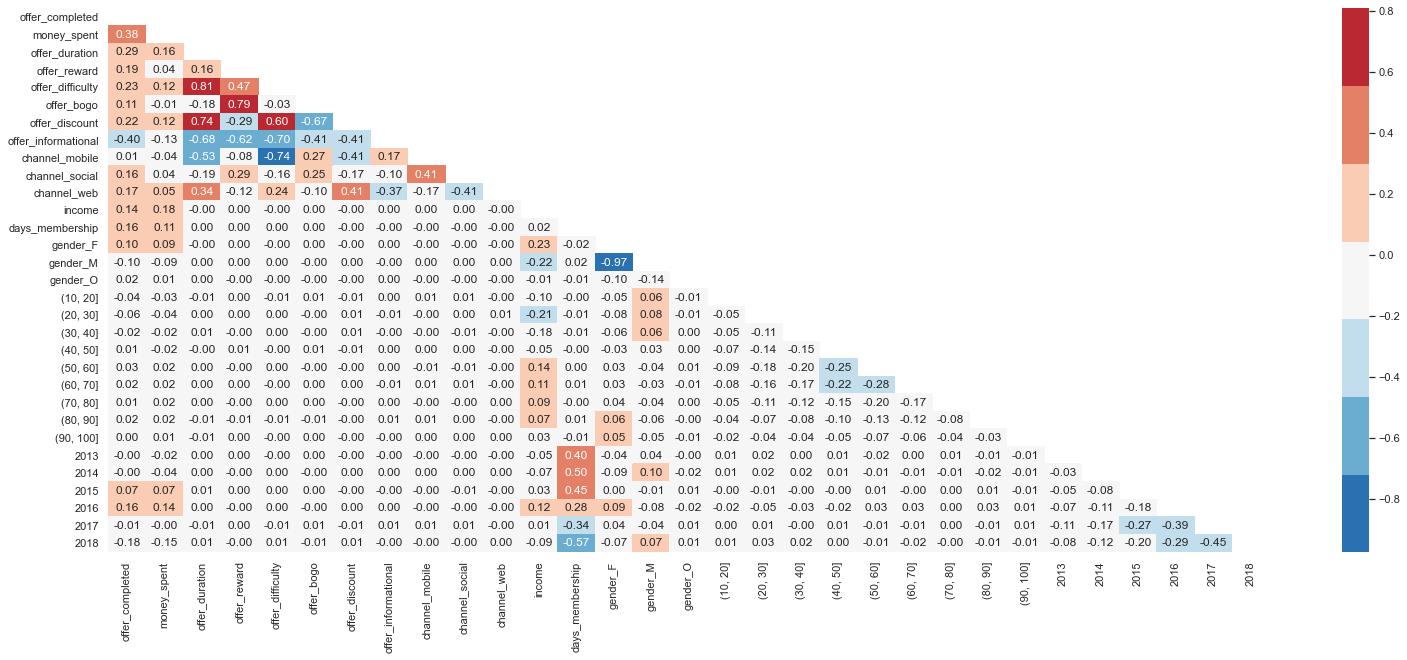

In [37]:

heatmap_vars = data

corr = heatmap_vars.corr()
mask = np.triu(corr)
cmap = sns.color_palette("RdBu_r", 7)

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize = (26, 10))
    ax = sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, fmt = '.2f')

figure = ax.get_figure()    

In [38]:
train = data[['money_spent', 'offer_duration', 'offer_reward', 'offer_difficulty', 
              'offer_discount', 'offer_informational', 'channel_social', 'channel_web',
              'days_membership', '2016', '2018']]
target = np.ravel(data[['offer_completed']])

In [39]:
model_opt = [LogisticRegression(),
             DecisionTreeClassifier(),
             AdaBoostClassifier(),
             RandomForestClassifier(),
             XGBClassifier()] 

model_cols = ['Model Name', 'Model Parameters', 'Model Test Accuracy']
model_df = pd.DataFrame(columns = model_cols)

counter = 0
for model in model_opt:
    
    model_name = model.__class__.__name__
    model_df.loc[counter, 'Model Name'] = model_name
    model_df.loc[counter, 'Model Parameters'] = str(model.get_params())
    
    accuracy = cross_val_score(model, train, target, cv = 10)
    
    model_df.loc[counter, 'Model Test Accuracy'] = np.mean(accuracy)
    
    counter += 1
    
model_df.sort_values(by = ['Model Test Accuracy'], ascending = False, inplace = True)

In [40]:
def plot_learning_curve(model_str, train_sizes, train_scores, validation_scores):
    '''
    Plotting the learning curve of a machine learning model given the input
    parameters

    Args:
        model_str (str): string model's name
        train_sizes (list): list of training sizes to be calculated
        train_scores (list): training scores of model (metrics)
        validation_scores (list): validation scores of model (metrics)
    Returns:
        None
        *this function plots learning curves with their std bounds
    '''
    figure, ax = plt.subplots(figsize = (8, 6))
    
    train_scores_mean = train_scores.mean(axis = 1)
    train_scores_std = train_scores.std(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    validation_scores_std = validation_scores.std(axis = 1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training Score', marker = 'o', color = 'r')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color = "r")
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Score', marker = 'o', color = 'g')
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                         validation_scores_mean + validation_scores_std, alpha=0.1,
                         color = "g")
    
    plt.ylabel('Accuracy')
    plt.xlabel('Training set size')
    plt.title('Learning curves for ' + str(model_str))
    plt.legend()
    plt.show()
    
    figure = ax.get_figure() 
    
    return

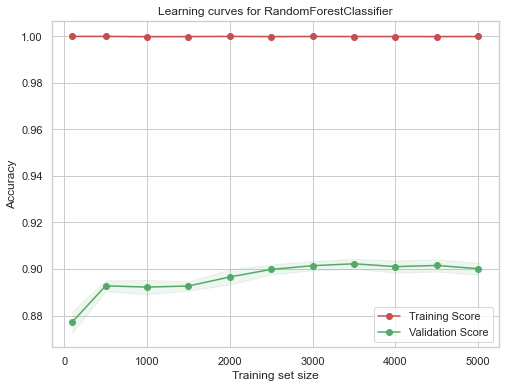

In [41]:
train_sizes = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

model = RandomForestClassifier()
                   
model.fit(train, target)
                   
train_sizes, train_scores, validation_scores = learning_curve(estimator = model, 
                                                              X = train, y = target, 
                                                              train_sizes = train_sizes, cv = 10)
plot_learning_curve('RandomForestClassifier', train_sizes, train_scores, validation_scores)

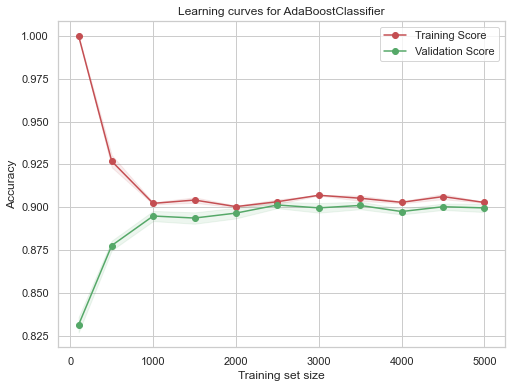

In [42]:
model = AdaBoostClassifier()                
model.fit(train, target)
                   
train_sizes, train_scores, validation_scores = learning_curve(estimator = model, 
                                                              X = train, y = target, 
                                                              train_sizes = train_sizes, cv = 10)
plot_learning_curve('AdaBoostClassifier', train_sizes, train_scores, validation_scores)

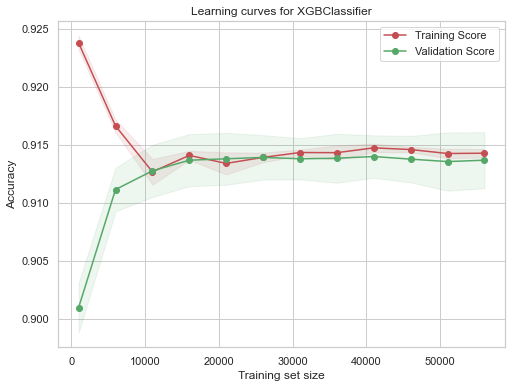

In [43]:
train_sizes = list(range(1000, 59000, 5000))
model = XGBClassifier()
                   
fit = model.fit(train, target)
                   
train_sizes, train_scores, validation_scores = learning_curve(estimator = model, 
                                                              X = train, y = target, 
                                                              train_sizes = train_sizes, cv = 10)
plot_learning_curve('XGBClassifier', train_sizes, train_scores, validation_scores)

In [44]:
model = XGBClassifier()

hyperparameters = {
                    'max_depth': [6], # 'max_depth': [3, 5, 6]
                    'booster': ['gbtree'], # 'booster': ['gbtree', 'gblinear']
                    'num_parallel_tree': [1] # 'num_parallel_tree': [1, 2]
}

grid = GridSearchCV(model, param_grid = hyperparameters, cv = 10, scoring =  ['accuracy', 'precision', 'f1'], refit = 'accuracy')
grid.fit(train, target)

best_params = grid.best_params_
best_score = grid.best_score_
tuned_model = grid.best_estimator_

In [45]:
print('Best parameters of XGB Classifier:', str(best_params))
print('The model accuracy is: ' + str(round(best_score*100,2)) + '%')

Best parameters of XGB Classifier: {'booster': 'gbtree', 'max_depth': 6, 'num_parallel_tree': 1}
The model accuracy is: 91.45%


In [48]:
fit_var = tuned_model.fit(train, target)

In [49]:
important_feature = fit_var.feature_importances_
feature_names = train.columns.tolist()
df_feature = pd.DataFrame(data = important_feature, columns = ['values'])
df_feature['feature_names'] = feature_names
df_feature = df_feature.sort_values(by = ['values'], ascending = False)
df_feature.head()

values     feature_names
1  0.415591    offer_duration
0  0.286335       money_spent
6  0.099435    channel_social
3  0.075800  offer_difficulty
2  0.070569      offer_reward

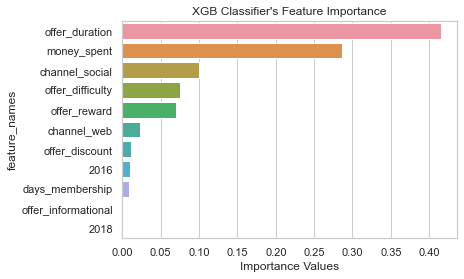

In [50]:
sns.barplot(data = df_feature, x = 'values', y = 'feature_names')
plt.title('XGB Classifier\'s Feature Importance')
plt.xlabel('Importance Values')
plt.show()